# QRNN

**For fair comparison and benchmarking no pretrained models will be used**

In [1]:
import os
os.environ['FASTAI_TB_CLEAR_FRAMES']="1"

In [2]:
from fastai.text import *
from fastai.data_block import *

In [3]:
data_path = Path("../../data/quora/")

In [4]:
train_df = pd.read_csv(data_path/'train.csv')
test_df = pd.read_csv(data_path/'test.csv')

In [5]:
train_df.shape, test_df.shape

((1306122, 3), (56370, 2))

In [6]:
train_df.head(1)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0


### LM Training

Now fastai supports a generic language model learner with `AWD-LSTM`, `QRNN`, `Transformer` and `Transformer XL`

In [ ]:
data_lm = TextLMDataBunch.load(".")

In [9]:
awd_lstm_lm_config = dict(emb_sz=300, n_hid=1150, n_layers=3,
                          pad_token=1, qrnn=True, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02,
                          weight_p=0.15, tie_weights=True, out_bias=True)

In [10]:
learn = language_model_learner(data=data_lm, arch=AWD_LSTM, config=awd_lstm_lm_config,
                               drop_mult=1.0, pretrained=False, clip=0)

In [11]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.51E-03


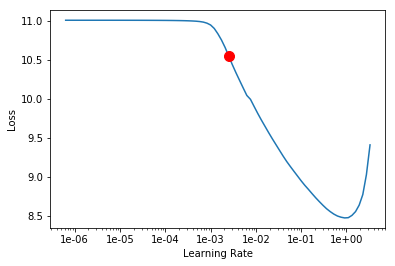

In [12]:
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,4.029510,3.862333,0.363767
2,3.967497,3.783418,0.368824
3,3.847000,3.678134,0.377079
4,3.747464,3.581915,0.385553
5,3.683069,3.550554,0.388136


In [15]:
learn.save_encoder("qrnn-enc")

### Metric

In [16]:
from utils import fbeta_binary

### Clas Training - Full Data

In [25]:
data_clas = TextClasDataBunch.load(".", bs=256)

In [26]:
awd_lstm_clas_config = dict(emb_sz=300, n_hid=1150, n_layers=3, 
                            pad_token=1, qrnn=True, output_p=0.4,
                            hidden_p=0.2, input_p=0.6,
                            embed_p=0.1, weight_p=0.5)

In [27]:
learn = text_classifier_learner(data=data_clas, arch=AWD_LSTM, bptt=70,
                                max_len=1500, drop_mult=1.0, config=awd_lstm_clas_config)

In [28]:
# loads and freezes up to -1:last layer
learn.load_encoder("qrnn-enc")

In [29]:
# metrics
learn.metrics = [fbeta_binary(thresh=t) for t in np.arange(0.1, 1., 0.2)]

In [30]:
learn.fit_one_cycle(10, max_lr=5e-2)

epoch,train_loss,valid_loss,fbeta_binary,fbeta_binary,fbeta_binary,fbeta_binary,fbeta_binary
1,0.201063,0.154344,0.346935,0.505758,0.415202,0.146504,0.001487
2,0.215299,0.189386,0.312684,0.447551,0.486999,0.442130,0.200504
3,0.214926,0.169510,0.306543,0.476453,0.432068,0.195091,0.006420
4,0.207198,0.182538,0.292577,0.457940,0.495398,0.380064,0.058012
5,0.218746,0.163524,0.306604,0.497949,0.354662,0.075170,0.000496
6,0.212810,0.166387,0.315644,0.482121,0.461728,0.282876,0.022466


KeyboardInterrupt: 

In [58]:
learn.freeze_to(-2)

In [54]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,fbeta_binary,fbeta_binary,fbeta_binary,fbeta_binary,fbeta_binary
1,0.131336,0.118289,0.537440,0.602921,0.539239,0.344604,0.062426
2,0.141112,0.114618,0.532096,0.620429,0.583880,0.433159,0.149079
3,0.127401,0.111131,0.550947,0.631125,0.591659,0.427508,0.123429
4,0.126695,0.110097,0.558933,0.637678,0.602186,0.444794,0.138650
5,0.130178,0.109493,0.556808,0.639643,0.589123,0.414590,0.107820


In [59]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,fbeta_binary,fbeta_binary,fbeta_binary,fbeta_binary,fbeta_binary
1,0.122937,0.109389,0.559518,0.641056,0.605163,0.438192,0.126484


In [68]:
learn.save("clas-stage-2")

In [69]:
# reduce batch size to fit to GPU
data_clas = TextClasDataBunch.load(".", bs=256)

In [70]:
learn.data = data_clas

In [71]:
learn.unfreeze()

In [74]:
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,fbeta_binary,fbeta_binary,fbeta_binary,fbeta_binary,fbeta_binary
1,0.136374,0.109900,0.558997,0.640714,0.625065,0.491251,0.164475
2,0.130976,0.108244,0.564539,0.644929,0.624721,0.481631,0.150383
3,0.118992,0.107121,0.570693,0.650654,0.620056,0.464563,0.137727
4,0.108783,0.106352,0.564691,0.651148,0.612644,0.437422,0.113982
5,0.111793,0.106536,0.572049,0.651017,0.615426,0.447986,0.133516


In [75]:
learn.save("clas-stage-final")

### Clas Training After LM - Sample Data